<a href="https://colab.research.google.com/github/natbcar/MachineLearning/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms 
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt 

In [2]:
# Switching to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Our device is {}".format(device))

Our device is cuda


In [3]:
# transform images to tensor and resize to 224x224
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loading in the CIFAR10 datasets
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform
)


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
class ResNetBlock(nn.Module):
  def __init__(self, num_convs, in_channels, out_channels, increase_channels, stride):
    super(ResNetBlock, self).__init__()

    # if we need to increase the channels then create a 1x1 convolution to pass 
    # the input through
    if increase_channels:
      self.increase_channels = nn.Conv2d(in_channels=in_channels, 
                                 out_channels=out_channels,
                                 stride=stride, 
                                 kernel_size=1)
    else:
      self.increase_channels = None

    layers = []
    for i in range(num_convs):
      # conv layer
      layers.append(nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels, 
                              kernel_size=3,
                              stride=stride,
                              padding=1))
      
      # add a batch norm layer to prevent over fitting
      layers.append(nn.BatchNorm2d(num_features=out_channels))

      # update in channels since num_channels stays the same through the block
      # once the dimension has been increased
      in_channels=out_channels

      # set stride to 1 so the shape won't be halved again
      stride=1

      # if we aren't at the last conv layer then add a relu activation to the list
      if i < (num_convs - 1):
        layers.append(nn.ReLU())

    # unpack the layers into nn.Sequential
    self.layers = nn.Sequential(*layers)
    self.ReLU = nn.ReLU()

  def forward(self, x):
    # pass the input through the conv layers
    f_x = self.layers(x)

    # adjust the size of the input if necessary
    if self.increase_channels:
      x = self.increase_channels(x)

    # add the input to output of conv layers and pass through relu
    return self.ReLU(f_x + x)

In [5]:
def build_block(num_residuals, in_channels, out_channels, up_sample=True):
  """
  function to build a ResNet block 
  """
  block = []
  for i in range(num_residuals):
    if i == 0 and up_sample:
      block.append(ResNetBlock(num_convs=2, in_channels=in_channels, out_channels=out_channels, increase_channels=True, stride=2))
    else:
      block.append(ResNetBlock(num_convs=2, in_channels=out_channels, out_channels=out_channels, increase_channels=False, stride=1))
  return block

In [6]:
class ResNet18(nn.Module):
  def __init__(self):
    super(ResNet18, self).__init__()

    self.resnet = nn.Sequential(
        # -- first conv layer --
        # 7x7 kernel, stride 2, 64 out channels, 112x112 output size
        # batchnormalization layer added before activation
        # zero padding of 3 is used to keep dimensions correct
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),

        # -- maxpool layer --
        # 3x3 kernel and stride 2, zero padding is used to keep the 
        # output size in accordance with the architecture in the paper
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

        # -- first residual block --
        *build_block(num_residuals=2, in_channels=64, out_channels=64, up_sample=False),

        # -- second residual block --
        *build_block(num_residuals=2, in_channels=64, out_channels=128, up_sample=True),

        # -- third residual block --
        *build_block(num_residuals=2, in_channels=128, out_channels=256, up_sample=True),

        # -- fourth residual block --
        *build_block(num_residuals=2, in_channels=256, out_channels=512, up_sample=True),

        # -- average pooling layer --
        nn.AdaptiveAvgPool2d(output_size=(1,1)),

        # Flatten output to prepare for linear layer
        nn.Flatten(),

        # -- fully connected linear layer --
        nn.Linear(512, 10)
    )

  def forward(self, x):
    logits = self.resnet(x)
    return logits 

In [7]:
# checking to make sure the dimensions are right
test_net = ResNet18()
x = torch.rand(size=(1, 3, 224, 224))
for layer in test_net.resnet:
  x = layer(x)
  print(layer.__class__.__name__, ' output shape: ', x.shape)

Conv2d  output shape:  torch.Size([1, 64, 112, 112])
BatchNorm2d  output shape:  torch.Size([1, 64, 112, 112])
ReLU  output shape:  torch.Size([1, 64, 112, 112])
MaxPool2d  output shape:  torch.Size([1, 64, 56, 56])
ResNetBlock  output shape:  torch.Size([1, 64, 56, 56])
ResNetBlock  output shape:  torch.Size([1, 64, 56, 56])
ResNetBlock  output shape:  torch.Size([1, 128, 28, 28])
ResNetBlock  output shape:  torch.Size([1, 128, 28, 28])
ResNetBlock  output shape:  torch.Size([1, 256, 14, 14])
ResNetBlock  output shape:  torch.Size([1, 256, 14, 14])
ResNetBlock  output shape:  torch.Size([1, 512, 7, 7])
ResNetBlock  output shape:  torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d  output shape:  torch.Size([1, 512, 1, 1])
Flatten  output shape:  torch.Size([1, 512])
Linear  output shape:  torch.Size([1, 10])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [13]:
# initializing hyper params
learning_rate = 1e-3
batch_size = 64
num_epochs = 5

In [14]:
# initialize data loaders
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [15]:
# initialize model, objective, and optimizer
model = ResNet18().cuda()
objective = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
# Track training loss, validation loss, accuracy
training_loss = []
validation_loss = []
accuracy = []

for epoch in range(num_epochs):

  model.train()
  # --- Train Model ---
  for i, (X, y) in enumerate(train_loader):

    size = len(train_loader.dataset)

    # --- Compute the prediction and loss ---
    X, y = X.cuda(), y.cuda()
    pred = model(X)
    loss = objective(pred, y)

    # --- Backpropigation ---
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    training_loss.append(loss.item())

    if i % 100 == 0:
      loss, current = loss.item(), i * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  # --- Validate Model ---
  with torch.no_grad():
    model.eval()
    size = len(test_loader.dataset)
    avg_loss, avg_acc = 0, 0
    for X, y in test_loader:
      X, y = X.cuda(), y.cuda()
      pred = model(X)
      avg_loss += objective(pred, y)
      avg_acc += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss /= size
    avg_acc /= size

    validation_loss.append(avg_loss)
    accuracy.append(avg_acc)

    print(f"Test Error: \n Accuracy: {(100*avg_acc):>0.1f}%, Avg loss: {avg_loss:>8f} \n")

loss: 2.340817  [    0/50000]
loss: 1.771595  [ 6400/50000]
loss: 1.790625  [12800/50000]
loss: 1.567643  [19200/50000]
loss: 1.423477  [25600/50000]
loss: 1.335673  [32000/50000]
loss: 1.252069  [38400/50000]
loss: 1.161745  [44800/50000]
Test Error: 
 Accuracy: 58.4%, Avg loss: 0.018403 

loss: 0.925331  [    0/50000]
loss: 1.019293  [ 6400/50000]
loss: 0.891970  [12800/50000]
loss: 0.872690  [19200/50000]
loss: 0.775584  [25600/50000]
loss: 0.744717  [32000/50000]
loss: 0.841771  [38400/50000]
loss: 0.892648  [44800/50000]
Test Error: 
 Accuracy: 71.2%, Avg loss: 0.013317 

loss: 0.715073  [    0/50000]
loss: 0.747038  [ 6400/50000]
loss: 0.754061  [12800/50000]
loss: 0.476025  [19200/50000]
loss: 0.641235  [25600/50000]
loss: 0.842051  [32000/50000]
loss: 0.616557  [38400/50000]
loss: 0.732215  [44800/50000]
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.009990 

loss: 0.527561  [    0/50000]
loss: 0.516190  [ 6400/50000]
loss: 0.604260  [12800/50000]
loss: 0.438707  [19200/50000]
loss

In [21]:
num_correct = 0
for i in range(len(test_data)):
  X, y = test_data[i]
  X = X.cuda()
  X = X.view(-1, 3, 224, 224)
  pred = model(X)
  num_correct += (pred.argmax(1) == y)

print(num_correct)
print(len(test_data))

print("accuracy: {}%".format((num_correct / len(test_data)).item() * 100))

tensor([8095], device='cuda:0')
10000
accuracy: 80.9499979019165%


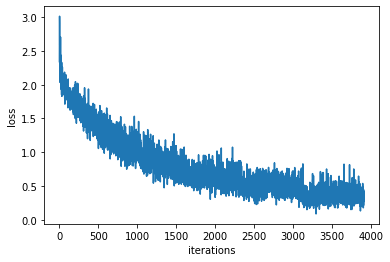

In [22]:
# Training loss
plt.plot([i for i in range(len(training_loss))], training_loss, label="training loss")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.show()

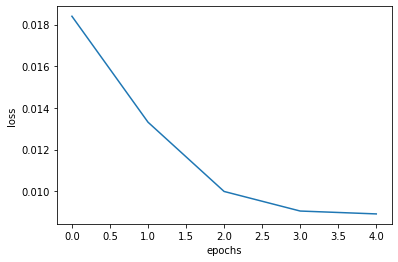

In [23]:
# Validation loss
plt.plot([i for i in range(len(validation_loss))], validation_loss, label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

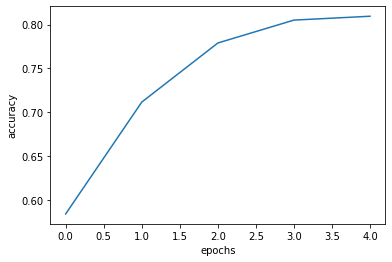

In [24]:
# Accuracy
plt.plot([i for i in range(len(accuracy))], accuracy, label="accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()